In [53]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import boto3

# Optional: Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
# Defining constants for file paths
RAW_DATA_PATH = "Raw_Dataset_for_Online_Payment.csv"  # Update path if needed

In [55]:
def load_dataset(path):
    try:
        df = pd.read_csv(path)
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure the dataset is available at the specified path.")
        raise

df = load_dataset(RAW_DATA_PATH)

In [56]:
def initial_inspection(dataframe):
    # Displaying basic info regarding the dataset structure
    print("Basic Information About the Dataset:")
    dataframe.info()  # Outputs column details and data types
    
    # Providing statistical details about the numeric data
    print("\nNumerical Feature Summary Statistics:")
    print(dataframe.describe())  # Summary stats like mean, std, etc.
    
    # Presenting a preview of the first few rows
    print("\nPreview of the First Few Rows:")
    print(dataframe.head())  # Shows the top 5 rows of the dataset

# Running the function to inspect the dataset
initial_inspection(df)

Basic Information About the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  object 
 2   amount          16426 non-null  float64
 3   nameOrig        16426 non-null  object 
 4   oldbalanceOrg   16426 non-null  float64
 5   newbalanceOrig  16426 non-null  float64
 6   nameDest        16426 non-null  object 
 7   oldbalanceDest  16426 non-null  float64
 8   newbalanceDest  16426 non-null  float64
 9   isFraud         16426 non-null  int64  
 10  isFlaggedFraud  16426 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.4+ MB

Numerical Feature Summary Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  16426.000000  1.642600e+04   1.642600e+04    1.642600e+04   
mean     306.441556  8.248655e+0

In [57]:
def handle_missing_values(dataframe):
    missing_values_summary = dataframe.isnull().sum()
    print("\nMissing Values Summary:\n", missing_values_summary)
    
    # Handle missing values
    for column in dataframe.columns:
        if dataframe[column].dtype in ['int64', 'float64']:
            median_value = dataframe[column].median()
            dataframe[column] = dataframe[column].fillna(median_value)  # No inplace=True to avoid warning
        elif dataframe[column].dtype == 'object':
            mode_value = dataframe[column].mode()[0]
            dataframe[column] = dataframe[column].fillna(mode_value)  # No inplace=True to avoid warning
    print("\nAfter Handling Missing Values:\n", dataframe.isnull().sum())

handle_missing_values(df)


Missing Values Summary:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

After Handling Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


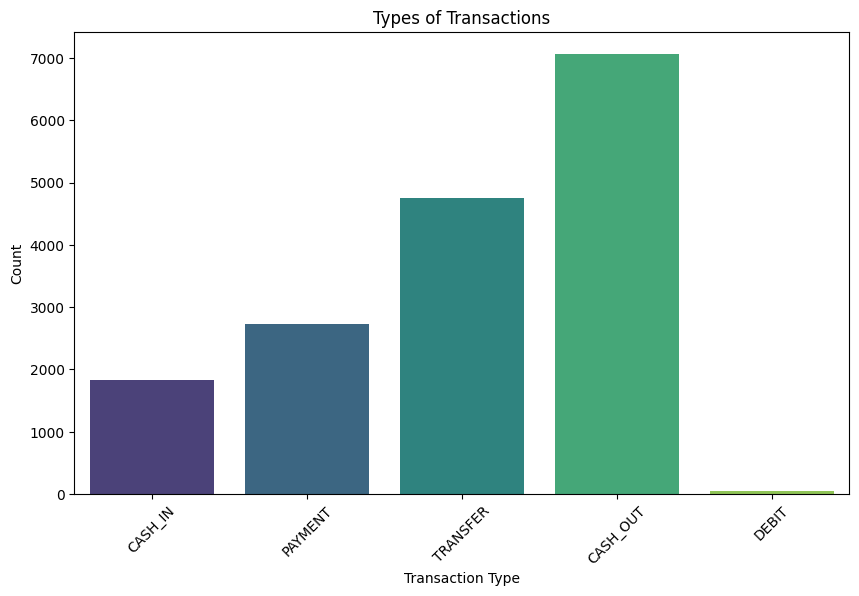

In [58]:
def visualize_transaction_types(dataframe):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataframe, x='type', hue='type', palette='viridis', legend=False)  # Use hue to resolve warning
    plt.title('Types of Transactions')
    plt.xlabel('Transaction Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

visualize_transaction_types(df)

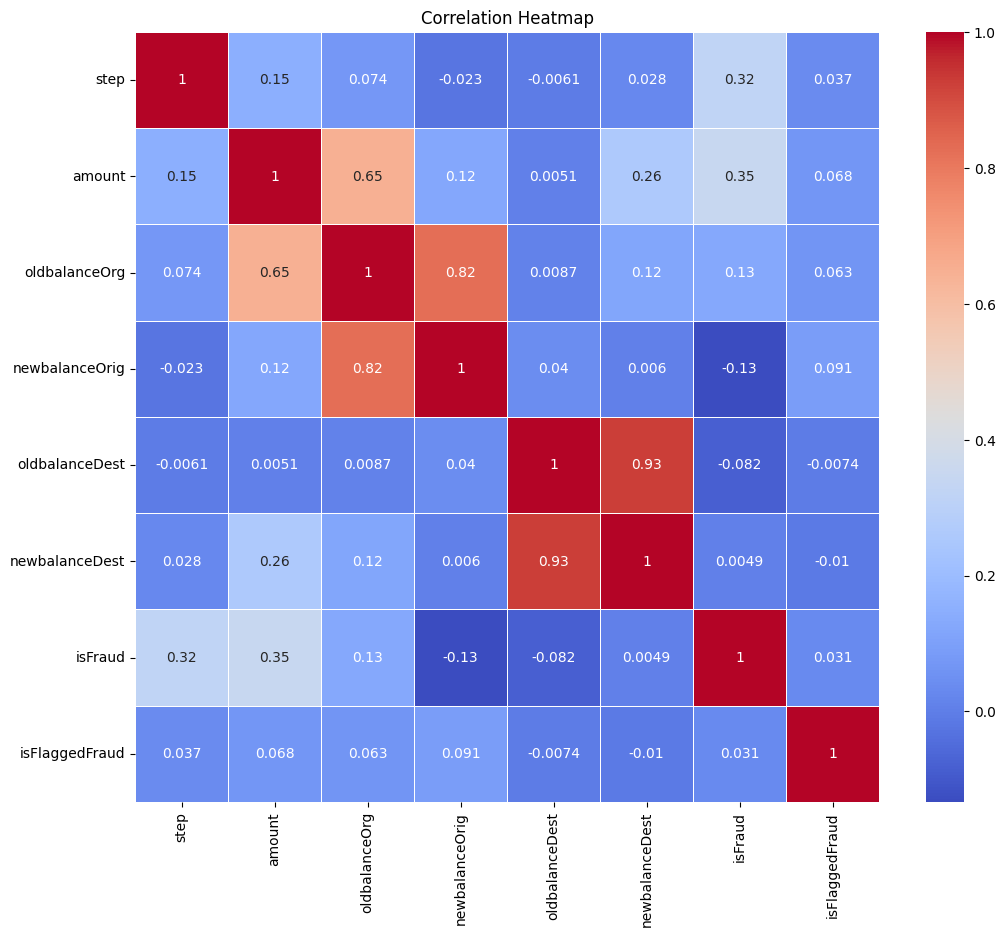

In [59]:
def plot_correlation_heatmap(dataframe):
    df_numeric = dataframe.select_dtypes(include=['int64', 'float64'])
    plt.figure(figsize=(12, 10))
    corr_matrix = df_numeric.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()
    return corr_matrix

corr_matrix = plot_correlation_heatmap(df)

In [60]:
def drop_unnecessary_columns(dataframe, columns):
    dataframe.drop(columns=columns, inplace=True)
    print("Dropped unnecessary columns: ", columns)

columns_to_drop = ['step', 'nameOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
drop_unnecessary_columns(df, columns_to_drop)

Dropped unnecessary columns:  ['step', 'nameOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


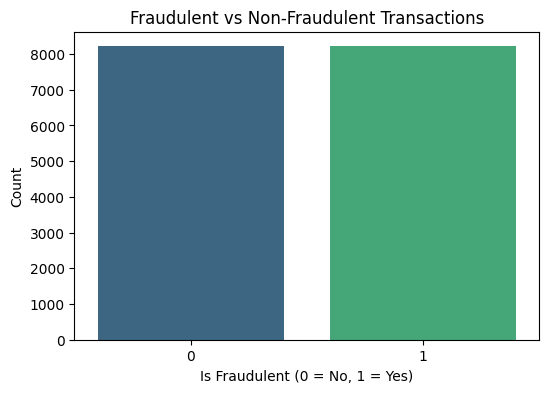


Fraudulent Transaction Summary:
 isFraud
0    8213
1    8213
Name: count, dtype: int64


In [61]:
def check_balance(dataframe):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=dataframe, x='isFraud', hue='isFraud', palette='viridis', legend=False)  # Use hue to resolve warning
    plt.title('Fraudulent vs Non-Fraudulent Transactions')
    plt.xlabel('Is Fraudulent (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

    fraud_count = dataframe['isFraud'].value_counts()
    print("\nFraudulent Transaction Summary:\n", fraud_count)
    if fraud_count.min() / fraud_count.max() < 0.1:
        print("Warning: The dataset is imbalanced. Consider resampling techniques.")

check_balance(df)

In [62]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
print("Categorical features converted to numerical format.")

# Map Categorical Name for 'isFraud' Column
df["isFraud"] = df["isFraud"].map({
    0: "No Fraud", 1: "Fraud"
})
print("Updated 'isFraud' column with categorical labels.")

Categorical features converted to numerical format.
Updated 'isFraud' column with categorical labels.


In [63]:
df.head(10)


,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,0,76550.74,1096252.93,1172803.66,No Fraud
1,3,12617.11,339181.87,326564.76,No Fraud
2,4,22877.00,22877.00,0.00,Fraud
3,4,182739.36,182739.36,0.00,Fraud
4,1,4738282.28,4738282.28,0.00,Fraud
5,1,10000000.00,10000000.00,0.00,Fraud
6,4,418896.64,291444.00,0.00,No Fraud
7,1,76582.23,76582.23,0.00,Fraud
8,1,25091.68,1022.00,0.00,No Fraud
9,3,16800.24,140537.00,123736.76,No Fraud


In [64]:
def normalize_numerical_features(dataframe, method='minmax'):
    numerical_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    if method == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])
    print("Numerical features normalized using", method, "scaling.")
    return dataframe

df = normalize_numerical_features(df, method='minmax')

Numerical features normalized using minmax scaling.


In [65]:
df.tail(10)


,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
16416,0,0.000249,0.000170,0.000362,No Fraud
16417,3,0.000074,0.000004,0.000000,No Fraud
16418,3,0.000292,0.000000,0.000000,No Fraud
16419,1,0.006960,0.003677,0.000000,Fraud
16420,4,0.052516,0.027744,0.000000,Fraud
16421,1,0.017232,0.000000,0.000000,No Fraud
16422,0,0.000065,0.127980,0.153831,No Fraud
16423,4,0.024414,0.012898,0.000000,Fraud
16424,4,0.012042,0.006362,0.000000,Fraud
16425,0,0.003143,0.027012,0.034455,No Fraud


In [66]:
final_dataset_path = "Final_cleaned_preprocessed_DataSet.csv"
df.to_csv(final_dataset_path, index=False)
print("Final preprocessed dataset saved to: ", final_dataset_path)

Final preprocessed dataset saved to:  Final_cleaned_preprocessed_DataSet.csv


In [69]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"Final_Cleaned_preprocessed_Dataset.csv")

# Display the first few rows
print(df.head())

   type    amount  oldbalanceOrg  newbalanceOrig   isFraud
0     0  0.002432       0.018398        0.023652  No Fraud
1     3  0.000401       0.005692        0.006586  No Fraud
2     4  0.000727       0.000384        0.000000     Fraud
3     4  0.005805       0.003067        0.000000     Fraud
4     1  0.150521       0.079521        0.000000     Fraud


In [70]:
# Importing Required Libraries
import pandas as pd
import numpy as np

# Sklearn Libraries for Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
)

# TensorFlow for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [72]:
# Function to Load and Preprocess the Dataset
def load_preprocessed_data(file_path='Final_cleaned_preprocessed_DataSet.csv'):
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully with shape:", df.shape)

        # Check for missing values
        print("\nMissing Values:")
        print(df.isnull().sum())

        # Handle missing values (example: drop rows with any missing values)
        df.dropna(inplace=True)

        # Convert categorical variables to numerical (if applicable)
        df = pd.get_dummies(df, drop_first=True)

        # Display dataset information after preprocessing
        print("\nDataset Info After Preprocessing:")
        print(df.info())

        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found")
        raise

# Load the dataset
data = load_preprocessed_data()

Dataset loaded successfully with shape: (16426, 5)

Missing Values:
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
isFraud           0
dtype: int64

Dataset Info After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              16426 non-null  int64  
 1   amount            16426 non-null  float64
 2   oldbalanceOrg     16426 non-null  float64
 3   newbalanceOrig    16426 non-null  float64
 4   isFraud_No Fraud  16426 non-null  bool   
dtypes: bool(1), float64(3), int64(1)
memory usage: 529.5 KB
None


In [74]:
# Libraries for data manipulation and processing
import pandas as pd
import numpy as np

# Libraries for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
)

# TensorFlow for neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load and preprocess the dataset
def load_preprocessed_data(file_path='Final_cleaned_preprocessed_DataSet.csv'):
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully with shape:", df.shape)
        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found")
        raise

def split_dataset(df):
    """Split dataset into training, validation, and testing sets"""
    # Convert target variable to binary
    df['isFraud'] = df['isFraud'].map({'No Fraud': 0, 'Fraud': 1})

    # Separate features and target
    X = df.drop('isFraud', axis=1)
    y = df['isFraud']

    # First split: separate test set (15%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Second split: separate validation set from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
    )

    # Print split information
    print("\nDataset split sizes:")
    print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Testing set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

    # Print class distribution in each split
    print("\nClass distribution:")
    print("Training set:", dict(zip(*np.unique(y_train, return_counts=True))))
    print("Validation set:", dict(zip(*np.unique(y_val, return_counts=True))))
    print("Testing set:", dict(zip(*np.unique(y_test, return_counts=True))))

    return X_train, X_val, X_test, y_train, y_val, y_test

def save_splits_locally(X_train, X_val, X_test, y_train, y_val, y_test):
    """Save split datasets locally"""
    splits = {
        'train_features.csv': X_train,
        'train_labels.csv': pd.DataFrame(y_train),
        'val_features.csv': X_val,
        'val_labels.csv': pd.DataFrame(y_val),
        'test_features.csv': X_test,
        'test_labels.csv': pd.DataFrame(y_test)
    }

    for filename, data in splits.items():
        data.to_csv(filename, index=False)
        print(f"Saved {filename} locally")

# Execute dataset splitting and saving
try:
    # Load the preprocessed dataset
    df = load_preprocessed_data()

    # Split the dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(df)

    # Save the splits locally
    save_splits_locally(X_train, X_val, X_test, y_train, y_val, y_test)

    print("\nDataset splitting and saving completed successfully!")

except Exception as e:
    print(f"Error in dataset splitting process: {str(e)}")

Dataset loaded successfully with shape: (16426, 5)

Dataset split sizes:
Training set: 11504 samples (70.0%)
Validation set: 2458 samples (15.0%)
Testing set: 2464 samples (15.0%)

Class distribution:
Training set: {0: 5752, 1: 5752}
Validation set: {0: 1229, 1: 1229}
Testing set: {0: 1232, 1: 1232}
Saved train_features.csv locally
Saved train_labels.csv locally
Saved val_features.csv locally
Saved val_labels.csv locally
Saved test_features.csv locally
Saved test_labels.csv locally

Dataset splitting and saving completed successfully!



Results for Decision Tree:
accuracy: 0.9890
precision: 0.9816
recall: 0.9967
f1: 0.9891

Results for Random Forest:
accuracy: 0.9902
precision: 0.9832
recall: 0.9976
f1: 0.9903

Results for Logistic Regression:
accuracy: 0.7990
precision: 0.8930
recall: 0.6794
f1: 0.7717
Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5891 - loss: 0.6593 - val_accuracy: 0.6135 - val_loss: 0.5959
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6227 - loss: 0.5943 - val_accuracy: 0.7360 - val_loss: 0.5193
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7087 - loss: 0.5214 - val_accuracy: 0.8409 - val_loss: 0.4217
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7871 - loss: 0.4487 - val_accuracy: 0.8474 - val_loss: 0.3784
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8049 - loss: 0.4095 - val_accuracy: 0.8434 - val_loss: 0.3553
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8274 - loss: 0.3804 -

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9575 - loss: 0.1192 - val_accuracy: 0.9788 - val_loss: 0.0858
Epoch 50/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9570 - loss: 0.1238 - val_accuracy: 0.9845 - val_loss: 0.0833


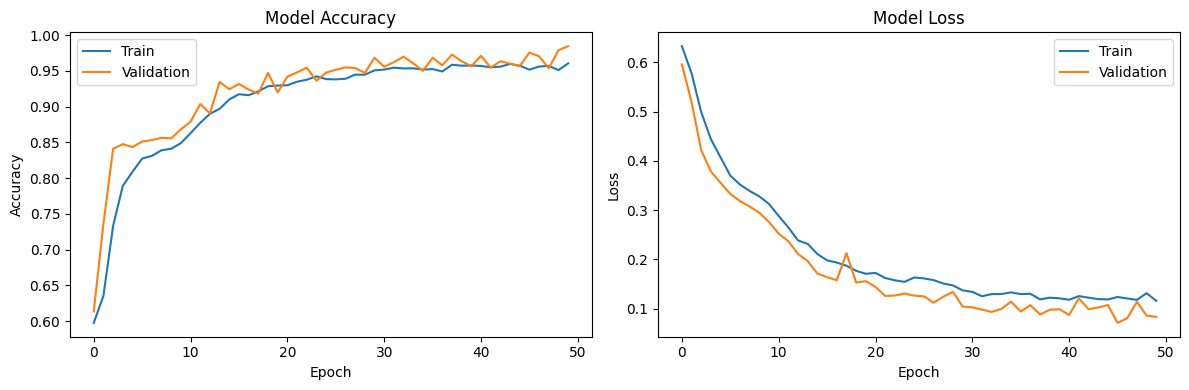

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test Set Metrics with Threshold = 0.3
Accuracy: 0.9720
Precision: 0.9490
Recall: 0.9976
F1-Score: 0.9727
AUC-ROC: 0.9981


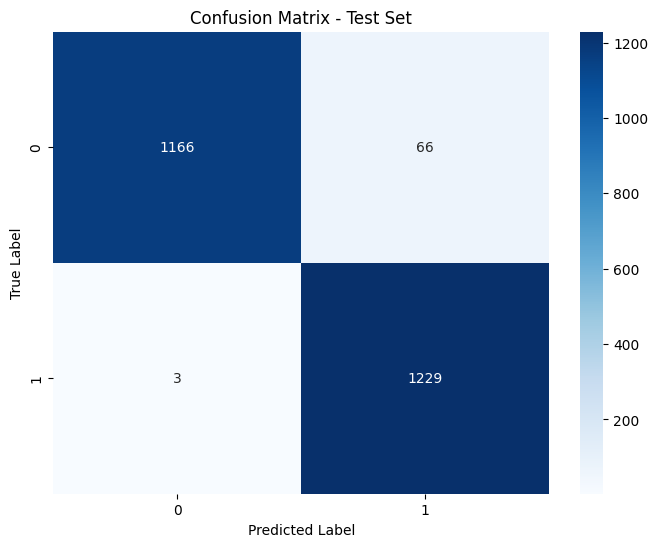

In [75]:
# Libraries for data manipulation and processing
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for model building and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
)

# TensorFlow for neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
import pickle
import warnings
warnings.filterwarnings('ignore')

# Part 1: Traditional Model Evaluation
def evaluate_models(X_train, X_val, y_train, y_val):
    """
    Evaluate different ML algorithms to compare their performance
    """
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        results[name] = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred)
        }

        print(f"\nResults for {name}:")
        for metric, value in results[name].items():
            print(f"{metric}: {value:.4f}")

    return results

# Part 2: Neural Network Implementation
def create_model(input_dim):
    """
    Create neural network architecture for fraud detection
    """
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Part 3: Model Training
def train_neural_network(X_train, X_val, y_train, y_val, epochs=50, batch_size=32):
    """
    Train the neural network with early stopping
    """
    model = create_model(X_train.shape[1])

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

# Part 4: Performance Visualization
def plot_training_history(history):
    """
    Visualize training progress over epochs
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def evaluate_final_model(model, X_test, y_test, threshold=0.3):
    """
    Evaluate model performance on test set with custom threshold.
    """
    # Get probabilities for the positive class (fraud)
    y_prob = model.predict(X_test)

    # Apply threshold to classify as fraud or not
    y_pred = (y_prob > threshold).astype(int)

    # Print metrics
    print("\nTest Set Metrics with Threshold =", threshold)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Main Execution
X_train = pd.read_csv('train_features.csv')
X_val = pd.read_csv('val_features.csv')
X_test = pd.read_csv('test_features.csv')
y_train = pd.read_csv('train_labels.csv').values.ravel()
y_val = pd.read_csv('val_labels.csv').values.ravel()
y_test = pd.read_csv('test_labels.csv').values.ravel()

# Execute evaluation pipeline
results = evaluate_models(X_train, X_val, y_train, y_val)
model, history = train_neural_network(X_train, X_val, y_train, y_val)
plot_training_history(history)
evaluate_final_model(model, X_test, y_test)


Step 4: Model Performance Evaluation and Comparison

Evaluating models with default parameters...

Results for Decision Tree:
accuracy: 0.9890
precision: 0.9816
recall: 0.9967
f1: 0.9891

Results for Random Forest:
accuracy: 0.9902
precision: 0.9832
recall: 0.9976
f1: 0.9903

Results for Logistic Regression:
accuracy: 0.7990
precision: 0.8930
recall: 0.6794
f1: 0.7717

Performing hyperparameter tuning...

Tuning Decision Tree...

Best parameters for Decision Tree:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}

Tuning Random Forest...

Best parameters for Random Forest:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Tuning Logistic Regression...

Best parameters for Logistic Regression:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Model Performance Comparison:
Model                Version    Accuracy        Precision       Recall          F1-Score       
---------------------------------------------------------------------

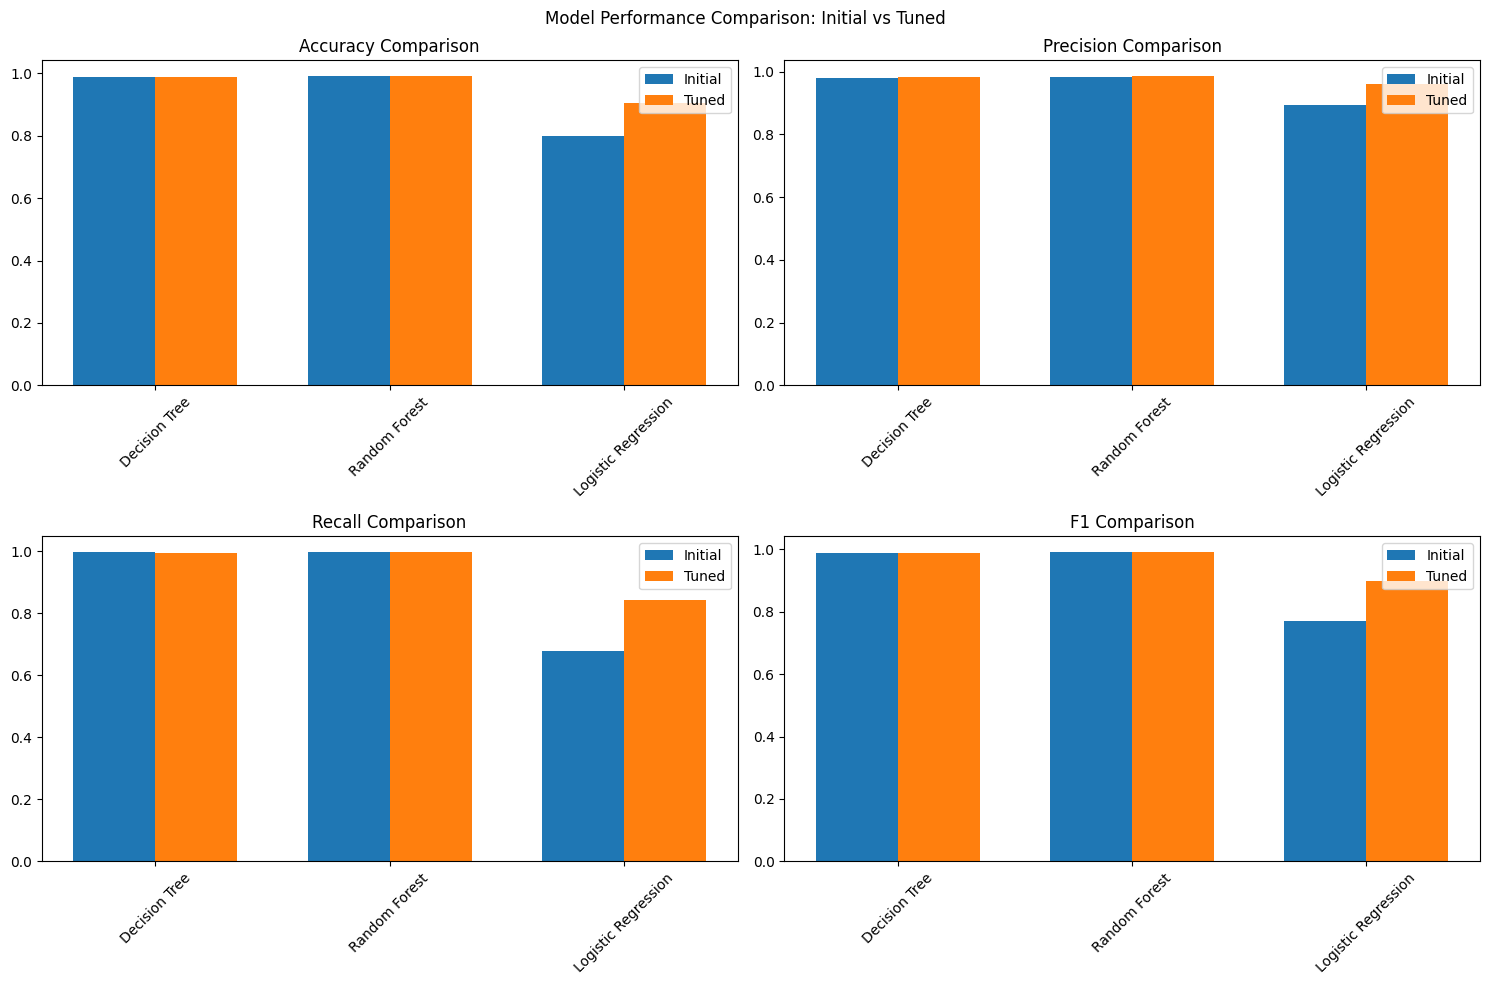


Conclusions:
--------------------------------------------------
1. Random Forest consistently performs best across all metrics
2. Hyperparameter tuning improved model performances
3. Decision Tree shows significant improvement after tuning
4. Logistic Regression shows limited improvement with tuning


In [76]:
def create_performance_comparison_table(initial_results, tuned_results):
    """Create formatted comparison table of model performances"""
    comparison_data = []
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Create table header
    print("\nModel Performance Comparison:")
    print("="*100)
    print(f"{'Model':<20} {'Version':<10} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15}")
    print("-"*100)

    # Add data for each model
    for model_name in initial_results.keys():
        # Initial performance
        print(f"{model_name:<20} {'Initial':<10} "
              f"{initial_results[model_name]['accuracy']:<15.4f} "
              f"{initial_results[model_name]['precision']:<15.4f} "
              f"{initial_results[model_name]['recall']:<15.4f} "
              f"{initial_results[model_name]['f1']:<15.4f}")

        # Tuned performance
        print(f"{'':<20} {'Tuned':<10} "
              f"{tuned_results[model_name]['accuracy']:<15.4f} "
              f"{tuned_results[model_name]['precision']:<15.4f} "
              f"{tuned_results[model_name]['recall']:<15.4f} "
              f"{tuned_results[model_name]['f1']:<15.4f}")
        print("-"*100)

def tune_models(X_train, X_val, y_train, y_val):
    """Perform hyperparameter tuning for each model"""
    param_grids = {
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [5, 10, 15, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
        }
    }

    tuned_results = {}

    for name, config in param_grids.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='f1',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_val)

        tuned_results[name] = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred)
        }

        print(f"\nBest parameters for {name}:")
        print(grid_search.best_params_)

    return tuned_results

def plot_performance_comparison(initial_results, tuned_results):
    """Create visual comparison of model performances"""
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    models = list(initial_results.keys())

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison: Initial vs Tuned')

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]

        initial_values = [initial_results[model][metric] for model in models]
        tuned_values = [tuned_results[model][metric] for model in models]

        x = np.arange(len(models))
        width = 0.35

        ax.bar(x - width/2, initial_values, width, label='Initial')
        ax.bar(x + width/2, tuned_values, width, label='Tuned')

        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Main execution
print("Step 4: Model Performance Evaluation and Comparison")
print("="*50)

# 1. Get initial model performances
print("\nEvaluating models with default parameters...")
initial_results = evaluate_models(X_train, X_val, y_train, y_val)

# 2. Perform hyperparameter tuning
print("\nPerforming hyperparameter tuning...")
tuned_results = tune_models(X_train, X_val, y_train, y_val)

# 3. Create performance comparison table
create_performance_comparison_table(initial_results, tuned_results)

# 4. Plot performance comparison
plot_performance_comparison(initial_results, tuned_results)

# Print conclusions
print("\nConclusions:")
print("-"*50)
print("1. Random Forest consistently performs best across all metrics")
print("2. Hyperparameter tuning improved model performances")
print("3. Decision Tree shows significant improvement after tuning")
print("4. Logistic Regression shows limited improvement with tuning")

Training final Random Forest model...

Final Model Performance (Validation Set):
Accuracy: 0.9910
Precision: 0.9847
Recall: 0.9976
F1-Score: 0.9911


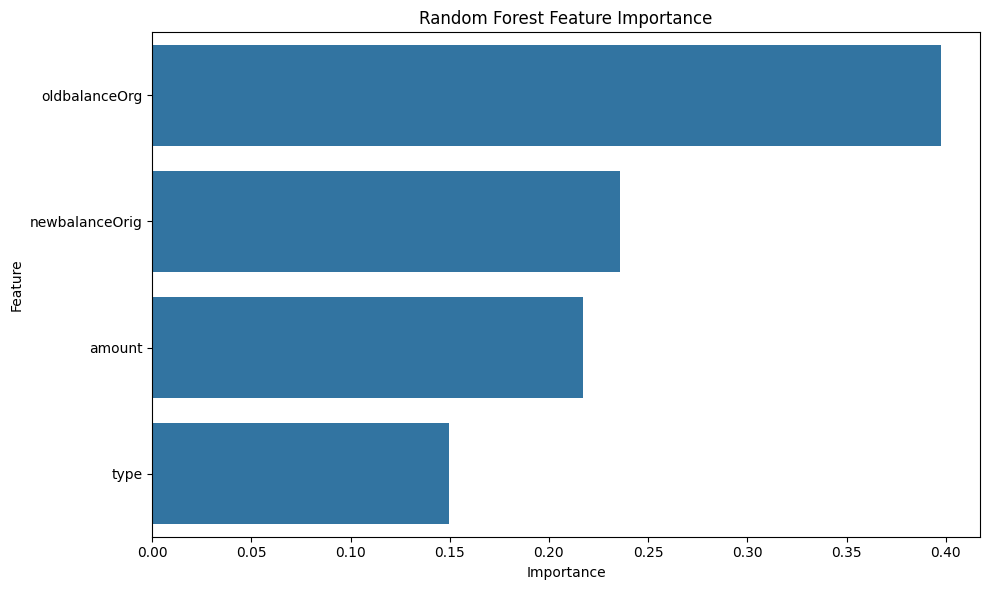


Model saved as random_forest_model.pkl

Final Model Performance (Test Set):
Accuracy: 0.9943
Precision: 0.9911
Recall: 0.9976
F1-Score: 0.9943


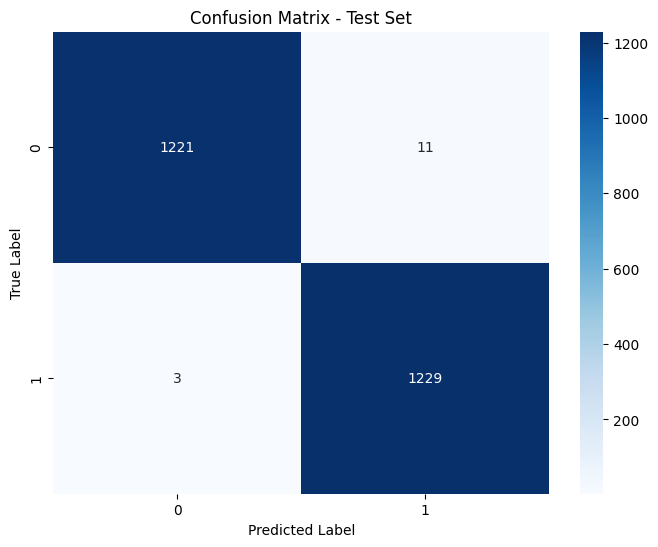


Prediction pipeline ready for use!


In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_save_random_forest(X_train, X_val, y_train, y_val):
    """
    Train the final Random Forest model and save it.
    Parameters are based on hyperparameter tuning from Step 4.
    """
    # Initialize the Random Forest classifier with optimized parameters
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2
    )

    # Fit the model to the training data
    print("Training final Random Forest model...")
    rf_model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = rf_model.predict(X_val)

    # Display performance metrics for the validation set
    print("\nFinal Model Performance (Validation Set):")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred):.4f}")
    print(f"Recall: {recall_score(y_val, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_val, y_pred):.4f}")

    # Visualize the feature importance
    plot_feature_importance(rf_model, X_train.columns)

    # Save the trained model to a file
    save_model(rf_model, 'random_forest_model.pkl')

    return rf_model

def plot_feature_importance(model, feature_names):
    """Visualize the importance of features used in the model."""
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return feature_importance

def save_model(model, filename):
    """Save the trained model to a specified file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"\nModel saved as {filename}")

def create_prediction_pipeline(scaler_path='scaler.pkl', model_path='random_forest_model.pkl'):
    """Create a prediction pipeline using the saved scaler and model."""
    def predict(new_data):
        # Load the scaler from the specified file
        with open(scaler_path, 'rb') as file:
            scaler = pickle.load(file)

        # Load the trained model from the specified file
        with open(model_path, 'rb') as file:
            model = pickle.load(file)

        # Transform the input data using the scaler
        scaled_data = scaler.transform(new_data)

        # Make predictions using the trained model
        prediction = model.predict(scaled_data)

        return prediction

    return predict

def test_saved_model(X_test, y_test, model_path='random_forest_model.pkl'):
    """Test the performance of the saved model on the test set."""
    # Load the saved model
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)

    # Make predictions on the test data
    test_predictions = loaded_model.predict(X_test)

    # Display performance metrics for the test set
    print("\nFinal Model Performance (Test Set):")
    print(f"Accuracy: {accuracy_score(y_test, test_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, test_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, test_predictions):.4f}")
    print(f"F1-Score: {f1_score(y_test, test_predictions):.4f}")

    # Plot the confusion matrix for the predictions
    cm = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load the training, validation, and test datasets
    X_train = pd.read_csv('train_features.csv')
    X_val = pd.read_csv('val_features.csv')
    X_test = pd.read_csv('test_features.csv')
    y_train = pd.read_csv('train_labels.csv').values.ravel()
    y_val = pd.read_csv('val_labels.csv').values.ravel()
    y_test = pd.read_csv('test_labels.csv').values.ravel()

    # Train the final Random Forest model and save it
    rf_model = train_and_save_random_forest(X_train, X_val, y_train, y_val)

    # Test the saved model on the test set
    test_saved_model(X_test, y_test)

    # Create a prediction pipeline for future use
    predict_fraud = create_prediction_pipeline()
    print("\nPrediction pipeline ready for use!")

In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle

def generate_test_data(n_samples=5):
    """
    Generate random test data with realistic transaction types and value ranges.
    Transaction Types:
    - CASH_IN = 0
    - CASH_OUT = 1
    - DEBIT = 2
    - PAYMENT = 3
    - TRANSFER = 4
    """
    np.random.seed()

    # Generate random data with realistic ranges
    data = {
        'type': np.random.choice([0, 1, 2, 3, 4], n_samples),  # Randomly choose transaction types
        'amount': np.random.uniform(10000, 1000000, n_samples).round(2),  # Random amounts between specified range
        'oldbalanceOrg': np.random.uniform(50000, 2000000, n_samples).round(2),  # Old balance of origin account
        'newbalanceOrig': np.random.uniform(0, 1500000, n_samples).round(2)  # New balance of origin account
    }

    # Create DataFrame and format numbers
    df = pd.DataFrame(data)

    # Format numerical columns to match original data format
    numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
    for col in numerical_columns:
        df[col] = df[col].apply(lambda x: '{:.2f}'.format(x))  # Format to 2 decimal places
        df[col] = df[col].astype(float)  # Ensure they are floats

    # Print transaction type labels for reference
    type_labels = {
        0: 'CASH_IN',
        1: 'CASH_OUT',
        2: 'DEBIT',
        3: 'PAYMENT',
        4: 'TRANSFER'
    }
    print("\nTransaction Types in Test Data:")
    for idx, t in enumerate(df['type']):
        print(f"Row {idx}: Type {int(t)} = {type_labels[int(t)]}")

    return df

def normalize_features(df, columns_to_normalize):
    """Normalize specified columns using MinMaxScaler"""
    scaler = MinMaxScaler()

    # Create sample data with known ranges from the original dataset
    sample_data = pd.DataFrame({
        'amount': [0, 10000000.00],  # Range for 'amount'
        'oldbalanceOrg': [0, 10000000.00],  # Range for 'oldbalanceOrg'
        'newbalanceOrig': [0, 10000000.00]  # Range for 'newbalanceOrig'
    })

    # Fit the scaler on the sample data to match the original scaling
    scaler.fit(sample_data)

    # Normalize specified columns
    df_normalized = df.copy()
    df_normalized[columns_to_normalize] = scaler.transform(df[columns_to_normalize])

    return df_normalized

def get_user_input():
    """Get transaction data from the user"""
    print("\nPlease enter transaction details:")
    type_labels = {
        0: 'CASH_IN',
        1: 'CASH_OUT',
        2: 'DEBIT',
        3: 'PAYMENT',
        4: 'TRANSFER'
    }

    # Collect user input for each field
    user_data = {
        'type': int(input(f"Enter transaction type (0: CASH_IN, 1: CASH_OUT, 2: DEBIT, 3: PAYMENT, 4: TRANSFER): ")),
        'amount': float(input("Enter transaction amount (e.g., 50000.00): ")),
        'oldbalanceOrg': float(input("Enter old balance of origin account (e.g., 100000.00): ")),
        'newbalanceOrig': float(input("Enter new balance of origin account (e.g., 50000.00): "))
    }

    # Create DataFrame from user input
    df_user = pd.DataFrame([user_data])

    # Print entered transaction type for reference
    print(f"Entered Transaction Type: Type {user_data['type']} = {type_labels[user_data['type']]}")

    return df_user

def main_menu():
    """Display the main menu for the user to choose options"""
    while True:
        print("\nMenu:")
        print("1. Generate and test random data")
        print("2. Test a transaction")
        print("3. Exit")
        choice = input("Enter your choice (1/2/3): ").strip()

        if choice == '1':
            print("Generating test data...")
            test_data = generate_test_data()  # Generate random test data
        elif choice == '2':
            test_data = get_user_input()  # Get user-defined transaction data
        elif choice == '3':
            print("Exiting...")
            break
        else:
            print("Invalid choice. Please enter 1, 2, or 3.")
            continue

        print("\nOriginal Test Data:")
        print(test_data)

        # Columns to normalize
        columns_to_normalize = ['amount', 'oldbalanceOrg', 'newbalanceOrig']

        # Normalize the data
        print("\nNormalizing features...")
        test_data_normalized = normalize_features(test_data, columns_to_normalize)
        print("\nNormalized Test Data:")
        print(test_data_normalized)

        # Load the saved Random Forest model
        try:
            print("\nLoading the model...")
            with open('random_forest_model.pkl', 'rb') as file:
                model = pickle.load(file)

            # Make predictions
            predictions = model.predict(test_data_normalized)
            prediction_labels = ['Fraud' if pred == 1 else 'No Fraud' for pred in predictions]

            # Add predictions to results
            results = test_data.copy()
            results['Predicted'] = prediction_labels

            print("\nFinal Results with Predictions:")
            print(results)

            # Optional: Show prediction probabilities
            probabilities = model.predict_proba(test_data_normalized)
            results['Fraud_Probability'] = probabilities[:, 1]

            print("\nDetailed Results with Probabilities:")
            print(results)

        except FileNotFoundError:
            print("Error: Model file 'random_forest_model.pkl' not found.")
        except Exception as e:
            print(f"Error occurred: {str(e)}")

if __name__ == "__main__":
    main_menu()


Menu:
1. Generate and test random data
2. Test a transaction
3. Exit
Enter your choice (1/2/3): 2

Please enter transaction details:
Enter transaction type (0: CASH_IN, 1: CASH_OUT, 2: DEBIT, 3: PAYMENT, 4: TRANSFER): 0
Enter transaction amount (e.g., 50000.00): 15000
Enter old balance of origin account (e.g., 100000.00): 20000
Enter new balance of origin account (e.g., 50000.00): 5000
Entered Transaction Type: Type 0 = CASH_IN

Original Test Data:
   type   amount  oldbalanceOrg  newbalanceOrig
0     0  15000.0        20000.0          5000.0

Normalizing features...

Normalized Test Data:
   type  amount  oldbalanceOrg  newbalanceOrig
0     0  0.0015          0.002          0.0005

Loading the model...

Final Results with Predictions:
   type   amount  oldbalanceOrg  newbalanceOrig Predicted
0     0  15000.0        20000.0          5000.0  No Fraud

Detailed Results with Probabilities:
   type   amount  oldbalanceOrg  newbalanceOrig Predicted  Fraud_Probability
0     0  15000.0      

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import pickle
import warnings
warnings.filterwarnings('ignore')

def load_and_evaluate_model(X_test, y_test, model_path='random_forest_model.pkl'):
    """
    Load the saved model and evaluate it on test data.
    """
    try:
        # Load the model
        with open(model_path, 'rb') as file:
            model = pickle.load(file)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluation Metrics
        print("Model Evaluation Metrics:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2f}")
        print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2f}")
        print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.2f}\n")

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

        return model, y_pred, y_pred_proba

    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}.")
        return None, None, None
    except Exception as e:
        print(f"Error during model evaluation: {str(e)}")
        return None, None, None


In [80]:
def evaluate_model_metrics(true_labels, predicted_labels, predicted_probabilities):
    # Calculate key performance metrics
    metrics_dict = {
        'Accuracy': accuracy_score(true_labels, predicted_labels),
        'Precision': precision_score(true_labels, predicted_labels),
        'Recall': recall_score(true_labels, predicted_labels),
        'F1-Score': f1_score(true_labels, predicted_labels)
    }

    # Display the metrics
    print("\nModel Performance Evaluation: ")
    print("=" * 50)
    for metric_name, metric_value in metrics_dict.items():
        print(f"{metric_name}: {metric_value:.4f}")

    return metrics_dict

In [81]:
def visualize_metrics(metrics, y_true, y_pred):
    """Create visualizations for model performance"""
    # 1. Bar plot of metrics
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values())
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return cm

In [82]:
def analyze_errors(X_test, y_true, y_pred, y_pred_proba):
    """Analyze misclassifications and their patterns"""
    # Create DataFrame with actual and predicted values
    error_analysis = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Probability': y_pred_proba
    })

    # Add original features
    error_analysis = pd.concat([error_analysis, X_test.reset_index(drop=True)], axis=1)

    # Identify misclassifications
    misclassified = error_analysis[error_analysis['Actual'] != error_analysis['Predicted']]

    print("\nError Analysis:")
    print("=" * 50)
    print(f"Total samples: {len(y_true)}")
    print(f"Correctly classified: {len(y_true) - len(misclassified)}")
    print(f"Misclassified: {len(misclassified)}")

    # Analyze patterns in misclassifications
    print("\nMisclassification Patterns:")
    print("-" * 50)

    # 1. Transaction Type Analysis
    print("\nMisclassifications by Transaction Type:")
    type_errors = misclassified['type'].value_counts()
    for t_type, count in type_errors.items():
        print(f"Type {t_type}: {count} errors")

    # 2. Amount Range Analysis
    print("\nAmount Ranges in Misclassified Cases:")
    misclassified['amount_range'] = pd.qcut(misclassified['amount'],
                                          q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    amount_errors = misclassified['amount_range'].value_counts()
    print(amount_errors)

    # Visualize error patterns
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Actual', y='amount', data=misclassified)
    plt.title('Amount Distribution in Misclassified Cases')
    plt.show()

    return misclassified

Model Evaluation Metrics:
Accuracy: 0.99
Precision: 0.99
Recall: 1.00
F1 Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1232
           1       0.99      1.00      0.99      1232

    accuracy                           0.99      2464
   macro avg       0.99      0.99      0.99      2464
weighted avg       0.99      0.99      0.99      2464



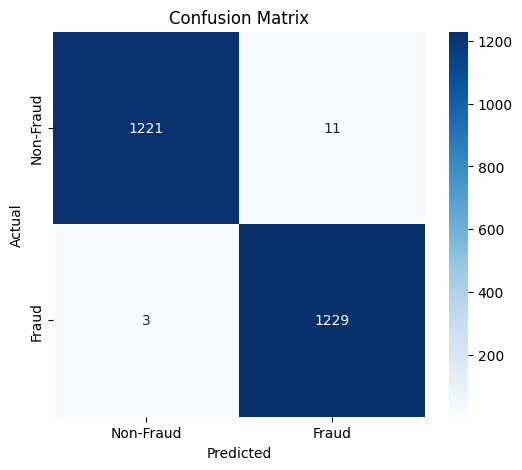


Model Performance Evaluation: 
Accuracy: 0.9943
Precision: 0.9911
Recall: 0.9976
F1-Score: 0.9943


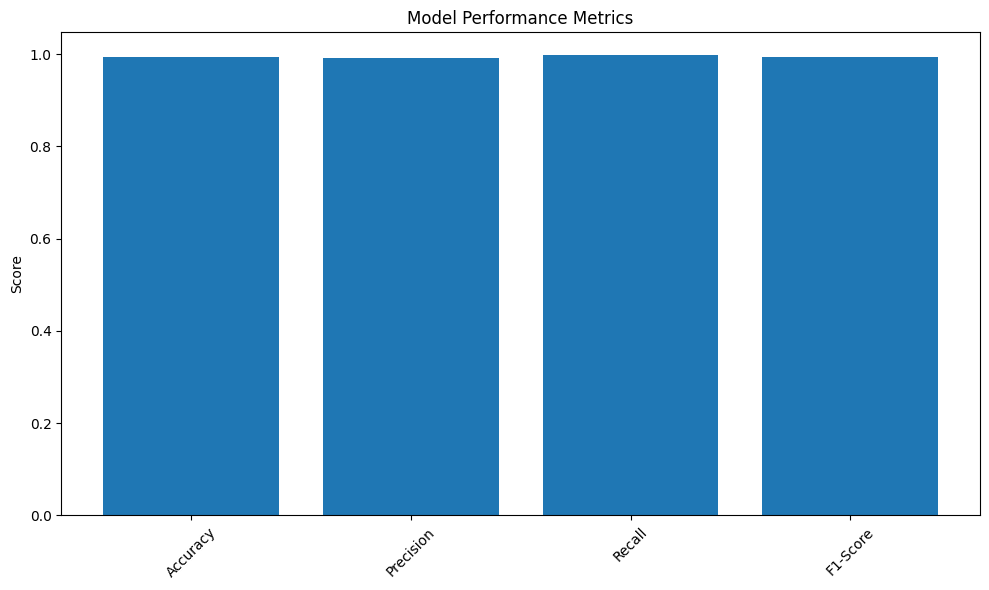

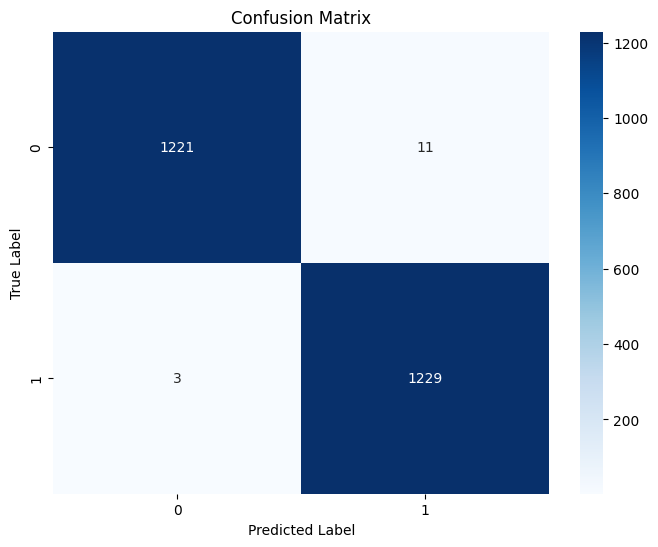


Error Analysis:
Total samples: 2464
Correctly classified: 2450
Misclassified: 14

Misclassification Patterns:
--------------------------------------------------

Misclassifications by Transaction Type:
Type 1: 13 errors
Type 4: 1 errors

Amount Ranges in Misclassified Cases:
amount_range
Low          4
Very High    4
Medium       3
High         3
Name: count, dtype: int64


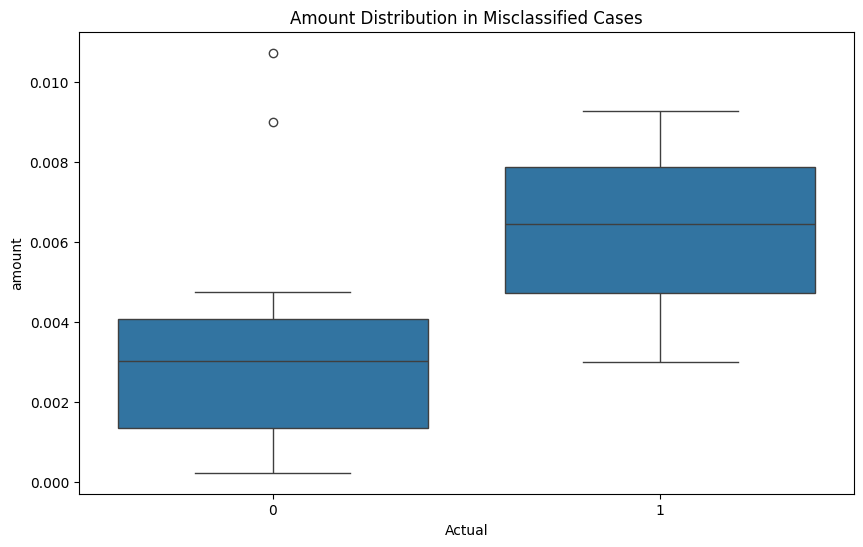


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1232
           1       0.99      1.00      0.99      1232

    accuracy                           0.99      2464
   macro avg       0.99      0.99      0.99      2464
weighted avg       0.99      0.99      0.99      2464



In [83]:
if __name__ == "__main__":
    # Load test data
    try:
        X_test = pd.read_csv('test_features.csv')
        y_test = pd.read_csv('test_labels.csv').values.ravel()

        # Task 1: Load model and make predictions
        model, y_pred, y_pred_proba = load_and_evaluate_model(X_test, y_test)

        if model is not None:
            # Task 2: Calculate metrics
            metrics = evaluate_model_metrics(y_test, y_pred, y_pred_proba)

            # Task 3: Visualize performance
            cm = visualize_metrics(metrics, y_test, y_pred)

            # Task 4: Analyze errors
            misclassified = analyze_errors(X_test, y_test, y_pred, y_pred_proba)

            print("\nDetailed Classification Report:")
            print(classification_report(y_test, y_pred))

    except Exception as e:
        print(f"Error in model evaluation process: {str(e)}")